## MODEL EVALUATION

In [1]:
# Libraries Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline


In [2]:
def wrangle(data_filename):
    '''
    Function loads dataset from filename
    
    Filters that loaded dataset in accordance with spelt out criteria in the homework
    
    Returns the final dataset
    '''
    #load data file
    df = pd.read_csv(data_filename)
    
    # Remove space and convert to lower case for columns names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    #Select features that are objects 
    col_list = list(df.dtypes[df.dtypes == 'object'].index)
    
    # Remove space and convert to lower case for observation for object features
    for col in col_list:
        df[col] = df[col].str.lower().str.replace(' ', '_')
        
    # fill missing values with 0
    df.fillna(0, inplace = True)    
  
    #Select the final feature for use in homework 
    df_final = df[['make', 'model', 'year', 'engine_hp', 'engine_cylinders', 'transmission_type', 'vehicle_style',
               'highway_mpg', 'city_mpg', 'msrp']]
    
    # Calculate Average Price
    avg_price = df_final.msrp.mean()

    # create a variable "above_average" which is 1 if the price is above its mean value and 0 otherwise
    df_final["above_average"] = (df_final.msrp > avg_price).astype(int)

    return df_final

def prepare_data_split(df, test_size, random_state, target_feature):
    '''
    Fuunction Split a dataset(df) in the ratio 60%/20%/20% == Train/Validation/Test
    
    return the train, Validation and Test dataset with their corresponding targer variable
    
    Note: the function does not remove the target feature
    '''
    df_full_train, df_test = train_test_split(df, test_size= test_size, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train[target_feature].values
    y_val = df_val[target_feature].values
    y_test = df_test[target_feature].values
    
    print(f"Length of Train: {len(df_train)}, Length of Validation: {len(df_val)}, Length of Test: {len(df_test)}")
    print()
    return df_train, y_train, df_val, y_val, df_test, y_test, df_full_train


def encode_OHE(df_train, df_val, df_test, sparse, columns):
    '''
    OneHot Encoding Implementation
    
    Returns: X_train, X_val, X_test
    '''
    dv = DictVectorizer(sparse=sparse)

    train_dict = df_train[columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    test_dict = df_test[columns].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    return X_train, X_val, X_test

def confusion_matrix(y_val, y_pred):
    scores = []

    #thresholds = np.arange(0.0, 1.01, 0.01)
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append([t, tp, fp, fn, tn])

    columns = ['Threshold', 'True_Positive', 'False_Positive', 'False_Negative', 'True_Negative']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


def train_model(df_train, y_train, cols, c):
    dicts = df_train[cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=c)
    model.fit(X_train, y_train)
    return dv, model

def predict(df_val, dv, model, cols):
    dicts = df_val[cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [3]:
# load data using the wrangle function

data_file_name = "week-4-car-data.csv"
df_final_1 = wrangle(data_file_name)

# Make copy of data for future use
df_final = df_final_1.copy(deep=True)
del df_final["msrp"]
df_final.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_14732\42398453.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["above_average"] = (df_final.msrp > avg_price).astype(int)


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0


In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   above_average      11914 non-null  int32  
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 884.4+ KB


In [6]:
df_final.shape

(11914, 10)

In [7]:
# INITIALIZING NUMERICAL AND CATEGORICAL VARIABLES WITHOUT TARGET VARIABLE:

numerical_cols = list(df_final.select_dtypes("number").columns.drop("above_average"))
categorical_cols = list(df_final.select_dtypes("object").columns)

full_columns = numerical_cols + categorical_cols

print("Numerical Columns: ", numerical_cols)
print("Categorical Columns: ", categorical_cols)

Numerical Columns:  ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
Categorical Columns:  ['make', 'model', 'transmission_type', 'vehicle_style']


In [8]:
# Setup Validation framework for logistic regression for dataset df_final

test_size = 0.2
random_state = 1
target = "above_average"
df_train, y_train, df_val, y_val, df_test, y_test, df_full_train = prepare_data_split(df_final, test_size,
                                                                                      random_state, target)

print("Train")
display(df_train.head())
print()
print("Validation")
display(df_val.head())
print()
print("Test")
display(df_test.head())
print()
print("Full_train")
display(df_full_train.head())


Length of Train: 7148, Length of Validation: 2383, Length of Test: 2383

Train


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,toyota,highlander_hybrid,2016,280.0,6.0,automatic,4dr_suv,28,27,1
1,chevrolet,impala_limited,2014,300.0,6.0,automatic,sedan,30,18,0
2,buick,regal,2016,259.0,4.0,automatic,sedan,27,19,0
3,volkswagen,cc,2015,280.0,6.0,automated_manual,sedan,25,17,1
4,dodge,grand_caravan,2016,283.0,6.0,automatic,passenger_minivan,25,17,0



Validation


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,nissan,370z,2015,350.0,6.0,automatic,coupe,26,19,1
1,pontiac,firebird,2000,305.0,8.0,unknown,2dr_hatchback,23,15,0
2,acura,rdx,2015,273.0,6.0,automatic,4dr_suv,27,19,0
3,kia,sedona,2016,276.0,6.0,automatic,passenger_minivan,24,18,0
4,nissan,truck,1996,134.0,4.0,manual,regular_cab_pickup,24,19,0



Test


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,lotus,evora_400,2017,400.0,6.0,manual,coupe,39,21,1
1,aston_martin,v8_vantage,2014,420.0,8.0,automated_manual,convertible,21,14,1
2,hyundai,genesis,2015,311.0,6.0,automatic,sedan,29,18,0
3,suzuki,samurai,1993,66.0,4.0,manual,convertible_suv,26,24,0
4,mitsubishi,outlander,2015,166.0,4.0,automatic,4dr_suv,29,24,0



Full_train


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
2711,mercedes-benz,clk-class,2007,382.0,8.0,automatic,coupe,22,15,1
333,nissan,370z,2016,332.0,6.0,manual,coupe,26,18,0
9377,gmc,sierra_1500,2017,285.0,6.0,automatic,extended_cab_pickup,24,18,0
939,porsche,911,2016,350.0,6.0,manual,convertible,26,19,1
5675,volkswagen,gti,2013,200.0,4.0,manual,4dr_hatchback,31,21,0


In [9]:
#ROC AUC SCORE:

auc_table = []
for col in numerical_cols:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    auc_table.append([col, auc])
    
final_tab = pd.DataFrame(auc_table, columns = ["numerical_feature", "roc_auc"])
display(final_tab)

f_list  = list(final_tab.roc_auc)
idx = f_list.index(max(f_list))

print(f"Highest AUC Feature: {final_tab.numerical_feature[idx]}, with AUC: {max(f_list)}")

,numerical_feature,roc_auc
0,year,0.687551
1,engine_hp,0.917103
2,engine_cylinders,0.766116
3,highway_mpg,0.633059
4,city_mpg,0.673424


Highest AUC Feature: engine_hp, with AUC: 0.9171031265539011


In [10]:
# Delete Target Variable for train set

target = "above_average"
del df_train[target]
del df_val[target]
del df_test[target]

In [11]:
# Q2

sparse = False
X_train, X_val, X_test = encode_OHE(df_train, df_val, df_test, sparse, full_columns)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

#ROC AUC SCORE:
print("AUC model on the validation dataset (round to 3 digits): ", round(roc_auc_score(y_val, y_pred), 3))

AUC model on the validation dataset (round to 3 digits):  0.976


In [12]:
df_scores = confusion_matrix(y_val, y_pred)
df_scores[::10]

,Threshold,True_Positive,False_Positive,False_Negative,True_Negative
0,0.0,654,1729,0,0
10,0.1,644,358,10,1371
20,0.2,625,226,29,1503
30,0.3,603,156,51,1573
40,0.4,585,112,69,1617
50,0.5,568,72,86,1657
60,0.6,518,52,136,1677
70,0.7,489,29,165,1700
80,0.8,427,14,227,1715
90,0.9,349,4,305,1725


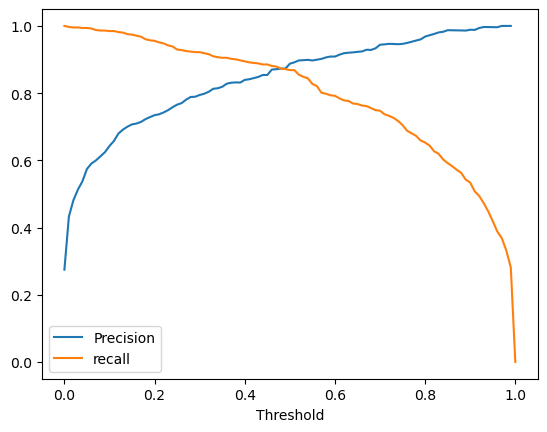

In [13]:
# Getting the Precision and Recall
df_scores['Precision'] = df_scores.True_Positive / (df_scores.True_Positive + df_scores.False_Positive)
df_scores['Recall'] = df_scores.True_Positive / (df_scores.True_Positive + df_scores.False_Negative)

#Plotof curves:
plt.plot(df_scores.Threshold, df_scores.Precision, label='Precision')
plt.plot(df_scores.Threshold, df_scores.Recall, label='recall')

plt.xlabel("Threshold")
plt.legend()
plt.show()

### At which threshold precision and recall curves intersect?   ANS= 0.48

In [14]:
#Calculating F1 SCORES:

df_scores['f1_score'] = 2 * df_scores.Precision * df_scores.Recall / (df_scores.Precision + df_scores.Recall)
df_scores[::10]

,Threshold,True_Positive,False_Positive,False_Negative,True_Negative,Precision,Recall,f1_score
0,0.0,654,1729,0,0,0.274444,1.000000,0.430688
10,0.1,644,358,10,1371,0.642715,0.984709,0.777778
20,0.2,625,226,29,1503,0.734430,0.955657,0.830565
30,0.3,603,156,51,1573,0.794466,0.922018,0.853503
40,0.4,585,112,69,1617,0.839311,0.894495,0.866025
50,0.5,568,72,86,1657,0.887500,0.868502,0.877898
60,0.6,518,52,136,1677,0.908772,0.792049,0.846405
70,0.7,489,29,165,1700,0.944015,0.747706,0.834471
80,0.8,427,14,227,1715,0.968254,0.652905,0.779909
90,0.9,349,4,305,1725,0.988669,0.533639,0.693148


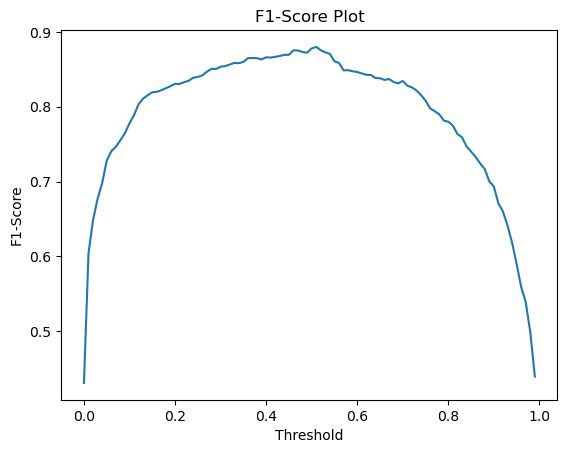


Threshold F1 is maximal: 0.51, with F1 Score: 0.8799380325329201


In [18]:
# Q4 - PLOTTING F1 SCORE:

plt.plot(df_scores.Threshold, df_scores.f1_score)
plt.title("F1-Score Plot")
plt.ylabel("F1-Score")
plt.xlabel("Threshold")
plt.show()


f_list  = list(df_scores.f1_score)
idx = f_list.index(max(f_list))
print()
print(f"Threshold F1 is maximal: {df_scores.Threshold[idx]}, with F1 Score: {max(f_list)}")

In [16]:
#Q5 - KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train_model(df_train, y_train, full_columns, c=1.0)
    y_pred = predict(df_val, dv, model, full_columns)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("Mean AUC Score: ", round(np.mean(scores),3), "Standard Deviation",round(np.std(scores), 3))

Mean AUC Score:  0.98 Standard Deviation 0.003


In [20]:
# Q6 INSPECTING KFOLD CROSS VALIDATION:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
matrix_table = []
for c in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train_model(df_train, y_train, full_columns, c=c)
        y_pred = predict(df_val, dv, model, full_columns)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    matrix_table.append([c, round(np.mean(scores), 3), np.std(scores)])
    
final_tab = pd.DataFrame(matrix_table, columns = ["C", "Mean_AUC_Score", "Standard_Deviation_AUC"])
display(final_tab)


,C,Mean_AUC_Score,Standard_Deviation_AUC
0,0.01,0.952,0.002488
1,0.10,0.972,0.001593
2,0.50,0.980,0.003494
3,10.00,0.982,0.003138


In [ ]:
# Q6 Answer = 10